# Unsupervised Clustering 

### These notebook does 3 things:
1. Ingest embeddings, performs Leiden algorithm, train_classifier to obtain embeddings.
2. Take a sparse image, pass (cropper, backbone, classifier) get a mask.
3. Transfer the mask to the dataframe

### Common Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

root_path = os.path.dirname(os.getcwd())
src_path = os.path.join(root_path, "src")
sys.path.insert(0, src_path)

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import numpy

from tissue_purifier.data_utils.datamodule import SlideSeqTestisDM
from tissue_purifier.model_utils.dino import DinoModel

### Read from file and re-create the model and datamodule

In [4]:
ckpt_file = 'ckpt_TIS_749.pt'
prediction_file = 'prediction_dict_loader0_TIS_749.pt'

prediction_loader0_v1 = torch.load(prediction_file)

for k,v in prediction_loader0_v1.items():
    if isinstance(v, torch.Tensor):
        print(k, type(v), v.shape)
    elif isinstance(v, list):
        print(k, type(v), len(v))
    else:
        print(k, type(v))
        
# Get the model from checkpoint
dino = DinoModel.load_from_checkpoint(ckpt_file)
config = dino._hparams
config["gpus"] = min(1, torch.cuda.device_count())

# Get the datamodule from config stored in the model
dm = SlideSeqTestisDM(**config)
dm_cropper = dm.cropper_reference
dm_transform = dm.trsfm_reference

# Extract the train_dataset made of full images
dm.prepare_data()
dm.setup()
train_loader = dm.train_dataloader()
train_dataset = train_loader.dataset

metadata <class 'list'> 7200
features_student_bbone <class 'torch.Tensor'> torch.Size([7200, 32])
features_teacher_bbone <class 'torch.Tensor'> torch.Size([7200, 32])
features_student_head <class 'torch.Tensor'> torch.Size([7200, 32])
features_teacher_head <class 'torch.Tensor'> torch.Size([7200, 32])
classify_tissue_label <class 'torch.Tensor'> torch.Size([7200])
classify_healthy_sick <class 'torch.Tensor'> torch.Size([7200])
regress_moran <class 'torch.Tensor'> torch.Size([7200])
-----> running datamodule init
-----> running datamodule prepare_data
number of elements ---> 31659
The dense shape of the image is -> torch.Size([9, 1168, 1168])
number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 1170, 845])
number of elements ---> 39206
The dense shape of the image is -> torch.Size([9, 1169, 1170])
number of elements ---> 27194
The dense shape of the image is -> torch.Size([9, 1166, 1170])
number of elements ---> 42776
The dense shape of the image is -> torch.S

# 1. Check reproducibility

### Compute the predictions from checkpoint (test_dataset will be different because random crops)

In [5]:
# from pytorch_lightning.trainer import Trainer
# from pytorch_lightning.plugins import DDPPlugin
# from tissue_purifier.model_utils.logger import NeptuneLoggerCkpt, PredictionWriter
#     
# pl_prediction_writer = PredictionWriter(write_interval='batch', output_dir="./predictions/")
# 
# pl_neptune_logger = NeptuneLoggerCkpt(
#     experiment_id=None,
#     close_after_fit=False,
#     offline_mode=True,
#     project_name='cellarium/tissue-purifier',  # change this to your project
#     experiment_name="Contrastive Learning",
#     tags=["arg"],
#     upload_source_files=["main*.py", "*.yaml"],
# )
#     
#     
# pl_trainer = Trainer(
#             gpus=1,  # number of gpu cards on a single machine to use
#             callbacks=[pl_prediction_writer],
#             plugins=DDPPlugin(find_unused_parameters=False),
#             logger=pl_neptune_logger,
#             precision=32
#         )
# 
# prediction_writer = [cb for cb in pl_trainer.callbacks if isinstance(cb, PredictionWriter)][0]
# 
# # v2 and v3 have the same test_dataset but different random transform
# pl_trainer.predict(model=dino,
#                    datamodule=dm,
#                    return_predictions=False)
# list_prediction_dict_v2 = prediction_writer.read(torch_device=torch.device("cuda"))
# predict_loader0_v2, predict_loader1_v2 = list_prediction_dict_v2
# 
# 
# pl_trainer.predict(model=dino,
#                    datamodule=dm,
#                    return_predictions=False)
# list_prediction_dict_v3 = prediction_writer.read(torch_device=torch.device("cuda"))
# predict_loader0_v3, predict_loader1_v3 = list_prediction_dict_v3

### Use tiling image

In [6]:
# from tissue_purifier.model_utils.patch_analyzer import PatchEncoder, PatchClusterer
# 
# train_loader = dm.train_dataloader()
# train_dataset = train_loader.dataset
# sp_img = train_dataset.imgs[0]
# 
# prediction_img0_only_v0 = sp_img.analyze_with_tiling(
#     cropper=dm.cropper_reference, 
#     analyzer=PatchEncoder(dino_model=dino, datamodule=dm), 
#     save_with_name="debugging_v0",
#     n_patches_max=1000,
#     recompute = True)
# 
# prediction_img0_only_v1 = sp_img.analyze_with_tiling(
#     cropper=dm.cropper_reference, 
#     analyzer=PatchEncoder(dino_model=dino, datamodule=dm), 
#     save_with_name="debugging_v1",
#     n_patches_max=1000,
#     recompute = True)

### Run PCA + UMAP

In [7]:
# from tissue_purifier.misc_utils.misc import SmartPca, SmartUmap, SmartLeiden
# 
# smart_pca = SmartPca(preprocess_strategy='z_score')
# smart_umap = SmartUmap(n_neighbors=25, preprocess_strategy='raw', n_components=2, min_dist=0.5)
# 
# def pipeline(input_features, first: bool = False):
#     if first:
#         features_pca = smart_pca.fit_transform(input_features, n_components=0.9)
#         features_umap = smart_umap.fit_transform(features_pca)
#     else:
#         features_pca = smart_pca.transform(input_features)
#         features_umap = smart_umap.transform(features_pca)
#     return features_pca, features_umap
# 
# p1, u1 = pipeline(prediction_loader0_v1['features_teacher_head'].cpu(), first=True)  # original saved in Neptune
# p2, u2 = pipeline(predict_loader0_v2['features_teacher_head'].cpu(), first=False)  # load ckpt and use predict 
# p3, u3 = pipeline(predict_loader0_v3['features_teacher_head'].cpu(), first=False)  # load ckpt and use predict again
# p4, u4 = pipeline(prediction_img0_only_v0['features_teacher_head'].cpu(), first=False)  # only image 0
# p5, u5 = pipeline(prediction_img0_only_v1['features_teacher_head'].cpu(), first=False)  # only image 0 again

In [8]:
# mask_wt1 = [tmp.f_name == 'wt1' for tmp in prediction_loader0_v1["metadata"]]
# mask_wt2 = [tmp.f_name == 'wt2' for tmp in prediction_loader0_v1["metadata"]]
# mask_wt3 = [tmp.f_name == 'wt3' for tmp in prediction_loader0_v1["metadata"]]
# mask_dis1 = [tmp.f_name == 'dis1' for tmp in prediction_loader0_v1["metadata"]]
# mask_dis2 = [tmp.f_name == 'dis2' for tmp in prediction_loader0_v1["metadata"]]
# mask_dis3 = [tmp.f_name == 'dis3' for tmp in prediction_loader0_v1["metadata"]]

In [9]:
#plt.scatter(p1[mask_wt1, 0], p1[mask_wt1, 1], s=1, color='orange')
#plt.scatter(p1[:, 0], p1[:, 1], s=1, color='gray')
#plt.scatter(p2[:, 0], p2[:, 1], s=1, color='red')
#plt.scatter(p3[:, 0], p3[:, 1], s=1, color='green')
#plt.scatter(p4[:, 0], p4[:, 1], s=1, color='blue')
#plt.scatter(p5[:, 0], p5[:, 1], s=1, color='brown')

# MYSTERY TO UNDERSTAND

In [10]:
#plt.scatter(u1[mask_wt1, 0], u1[mask_wt1, 1], s=1, color='orange')
#plt.scatter(u1[:, 0], u1[:, 1], s=1, color='gray')
#plt.scatter(u2[:, 0], u2[:, 1], s=1, color='red')
#plt.scatter(u3[:, 0], u3[:, 1], s=1, color='green')
#plt.scatter(u4[:, 0], u4[:, 1], s=1, color='blue')
#plt.scatter(u5[:, 0], u5[:, 1], s=1, color='brown')

- OK: Orange vs Blue ->  Subsetting the original point clounds to only wt1 reproduce the results for "sp_img.analyze_with_tiling"
- PROBLEM: Gray vs Red -> the checkpoint used to produce the two must be different.....
- OK: Red vs Green -> difference due to random transform only (datamadule.setup() runs only once)
- OK: Blue vs Brown -> difference due to random transform and random crops on a single image 

# 2. Unsupervised CLustering with Scanpy

In [11]:
# import pandas as pd
# import scanpy as sc
# from tissue_purifier.misc_utils.misc import get_z_score
# 
# tmp_dict = {
#     "conditions" : [0 if metadata.f_name.startswith("wt") else 1 for metadata in predictions['metadata']],
#     "f_names" : [metadata.f_name for metadata in predictions['metadata']],
#     "morans" : [metadata.moran for metadata in predictions['metadata']],
# }
# 
# df = pd.DataFrame(tmp_dict)
# 
# features = get_z_score(predictions['features_teacher_head'].float(), dim=-2)
# 
# adata = sc.AnnData(X=features.cpu().numpy(), obs=df)
# adata.obsm['X_raw'] = features.cpu().numpy()

In [12]:
#sc.tl.pca(adata, svd_solver='arpack', n_comps=30)
# sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca', method='umap', metric='euclidean')
# _ = plt.hist(adata.obsp['connectivities'].data, bins=50)

In [13]:
# sc.tl.leiden(adata, resolution=0.3)
# sc.tl.umap(adata)

In [14]:
# sc.pl.umap(adata, color=['leiden'], color_map=plt.cm.tab10)

# 3. Unsupervised Clustering with Custon Functions

In [15]:
from tissue_purifier.misc_utils.misc import SmartPca, SmartUmap, SmartLeiden

In [47]:
input_features = prediction_loader0_v1['features_student_head']
list_of_names = [tmp.f_name for tmp in prediction_loader0_v1["metadata"]]

smart_pca = SmartPca(preprocess_strategy='z_score')
smart_umap = SmartUmap(n_neighbors=25, preprocess_strategy='raw', n_components=2, min_dist=0.5)

embeddings_pca = smart_pca.fit_transform(input_features, n_components=0.9)
embeddings_umap = smart_umap.fit_transform(embeddings_pca)
umap_graph = smart_umap.get_graph()

In [55]:
smart_leiden = SmartLeiden(graph=umap_graph)
cluster_labels = smart_leiden.cluster(resolution=0.01)

print(embeddings_pca.shape)
print(embeddings_umap.shape)
print(cluster_labels.shape)

(7200, 10)
(7200, 2)
(7200,)


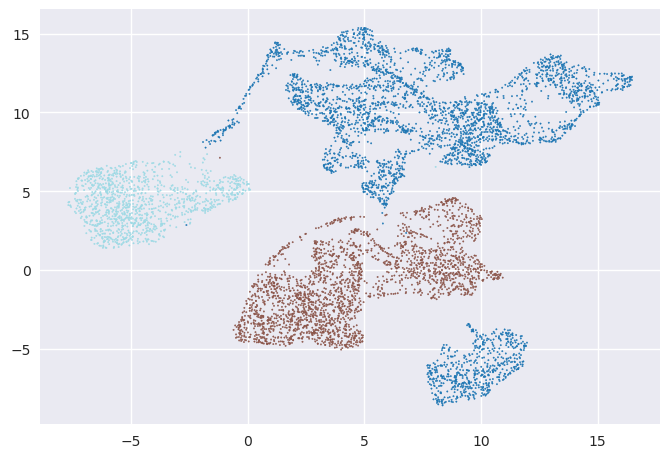

In [56]:
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], s=1, c=cluster_labels, cmap=plt.cm.tab20)

In [57]:
from tissue_purifier.plot_utils.plot_embeddings import plot_embeddings

fig = plot_embeddings(embeddings_umap,
        size=5,
        cmap=plt.cm.tab10,
        labels=list_of_names)

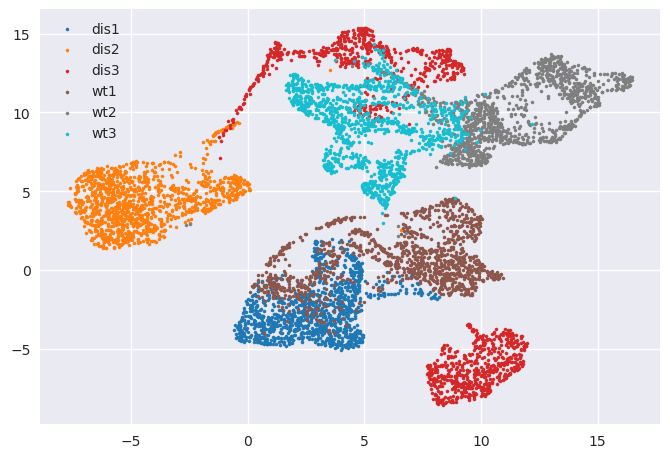

In [58]:
fig

### Train a simple NearestNeighbour classifier to predict cluster labels

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = embeddings_pca
y = cluster_labels.astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify=y, 
    test_size=0.5,
    random_state=1,
    shuffle=True,
)

# Train the classifier and evaluate the performance
kn_classifier = KNeighborsClassifier(5)
kn_classifier.fit(X_train, y_train)
score_test = kn_classifier.score(X_test, y_test)
score_train = kn_classifier.score(X_train, y_train)
y_predicted = kn_classifier.predict(X)


# Make a figure
panel_size = 8
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(2*panel_size, panel_size))

axes[0].set_title("Input data")
axes[0].scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], s=1, c=y, cmap=plt.cm.tab10)   
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")
    
mask = (y_predicted == y)
axes[1].set_title("train, test scores --> ({0:.3}, {1:.3})".format(score_train, score_test))
axes[1].scatter(embeddings_umap[mask, 0], embeddings_umap[mask, 1], s=1, c=y_predicted[mask], cmap=plt.cm.tab20)
axes[1].scatter(embeddings_umap[~mask, 0], embeddings_umap[~mask, 1], s=20, c=y_predicted[~mask], cmap=plt.cm.tab20)
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")

AttributeError: 'Tensor' object has no attribute 'astype'

### Analyze entire images with tiling

In [21]:
sp_images = train_dataset.imgs
labels = train_dataset.codes
metadatas = train_dataset.metadatas
list_f_names = [metadata.f_name for metadata in  metadatas]
cell_names = sp_images[0].code_to_cat.values()

In [22]:
vars(smart_pca)

{'preprocess_strategy': 'z_score',
 '_fitted': True,
 '_n_components': tensor(10),
 '_U': tensor([[-0.2826,  0.1846,  0.0740,  ..., -0.1022,  0.0287,  0.3996],
         [ 0.0470, -0.0290, -0.1423,  ...,  0.1138,  0.0278, -0.0026],
         [ 0.2049, -0.1648, -0.3237,  ...,  0.2956,  0.1951,  0.5024],
         ...,
         [ 0.1905, -0.0038, -0.0395,  ...,  0.1175,  0.0417, -0.0026],
         [ 0.1069,  0.2896, -0.1064,  ...,  0.2046,  0.0183,  0.1549],
         [ 0.0661, -0.2145, -0.0060,  ...,  0.0228, -0.2560, -0.1319]]),
 '_explained_variance': tensor([0.2244, 0.3763, 0.4829, 0.5876, 0.6784, 0.7549, 0.8164, 0.8605, 0.8798,
         0.8958, 0.9074, 0.9186, 0.9283, 0.9373, 0.9459, 0.9531, 0.9603, 0.9665,
         0.9716, 0.9757, 0.9794, 0.9829, 0.9863, 0.9893, 0.9918, 0.9939, 0.9960,
         0.9977, 0.9988, 0.9993, 0.9998, 1.0000]),
 '_mean': tensor([[ 0.1354, -0.3918, -0.0168, -0.3188, -0.0970, -0.0017, -0.3809,  0.1328,
           0.1598,  0.0373,  0.0838, -0.4666,  0.1058,  0.019

In [23]:
from tissue_purifier.model_utils.patch_analyzer import PatchEncoder, PatchClusterer

# For each image run the classify method  
for n, sp_img in enumerate(sp_images):
    classifier_mask = sp_img.analyze_with_tiling(
        cropper=dm.cropper_reference, 
        analyzer=PatchClusterer(
            feature_extractor=dino,
            transform=dm.trsfm_reference,
            smart_pca=smart_pca,
            classifier=kn_classifier), 
    save_with_name="niche",
    n_patches_max=1000,
    batch_size=128,
    recompute = True)
        

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [24]:
print(sp_images[0].image_properties['niche'].shape)

torch.Size([12, 1168, 1168])


### Visualize the masks

In [25]:
from tissue_purifier.plot_utils.plot_images import show_raw_all_channels, show_raw_one_channel
from tissue_purifier.plot_utils.plot_misc import plot_counters
from tissue_purifier.misc_utils.misc import channel_counter_in_window

print(sp_images[0].image_properties['niche'].shape)

torch.Size([12, 1168, 1168])


In [26]:
for sp_img in sp_images:
    # Find the argmax of the niches
    value, index = torch.max(sp_img.image_properties['niche'], dim=-3)
    cluster_labels = torch.where(value > 0.25, index, -1 * torch.ones_like(index))
    sp_img.image_properties['niche_argmax'] = cluster_labels
    
    # Check the normalization to one
    normalization = torch.sum(sp_img.image_properties['niche'], dim=-3)
    sp_img.image_properties['niche_normalization'] = normalization

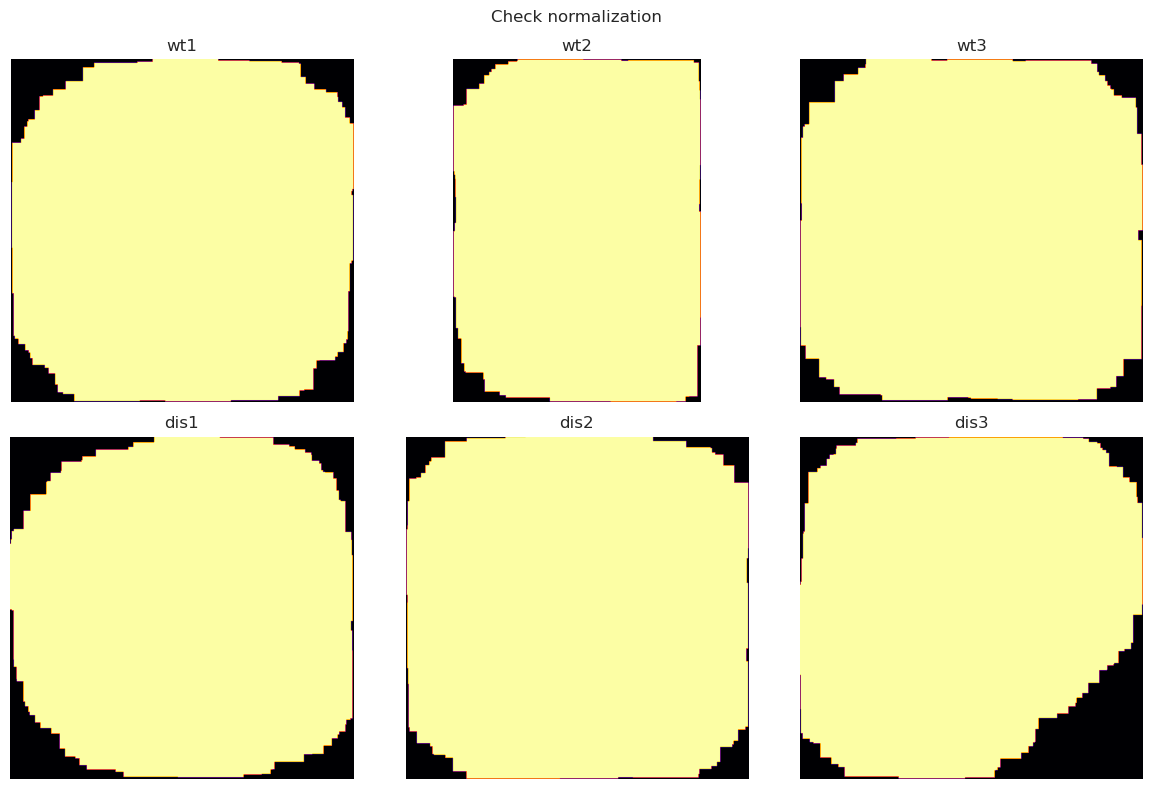

In [27]:
show_raw_one_channel([sp_img.image_properties['niche_normalization'] for sp_img in sp_images], n_col=3, labels=list_f_names, title="Check normalization")

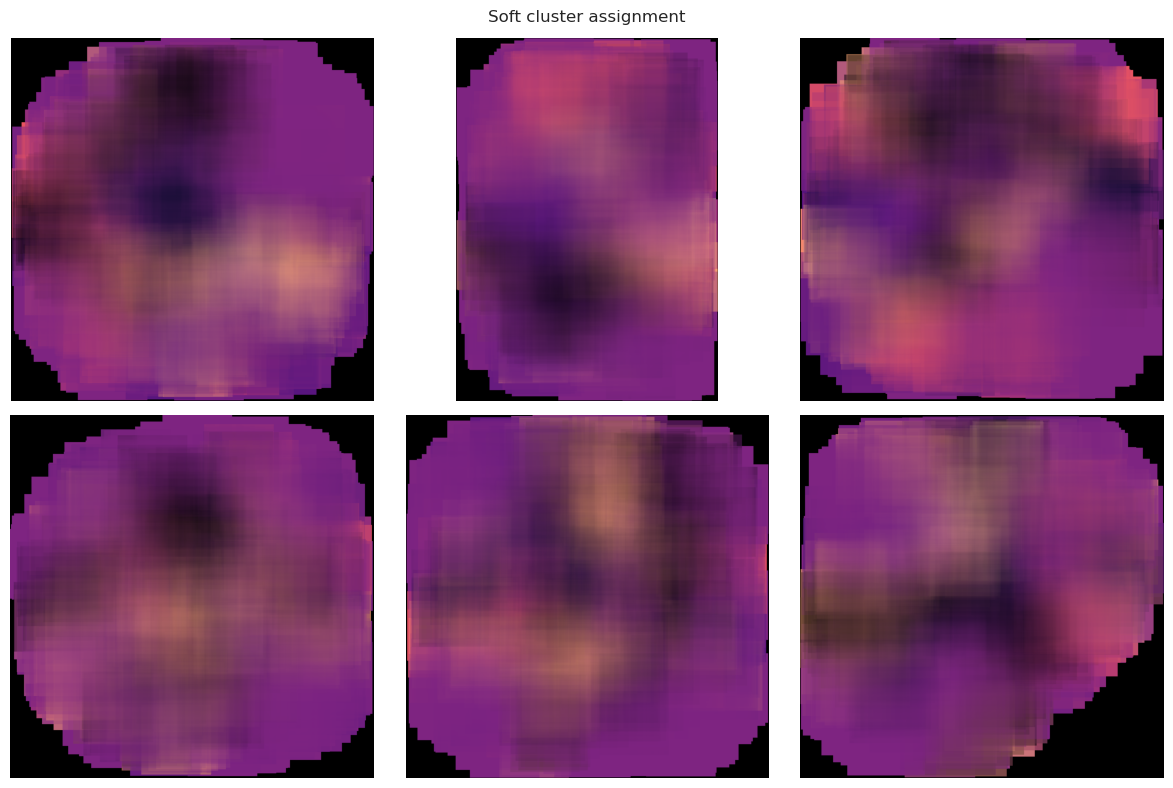

In [28]:
show_raw_all_channels([sp_img.image_properties['niche'] for sp_img in sp_images], cmap="magma", n_col=3, title="Soft cluster assignment")

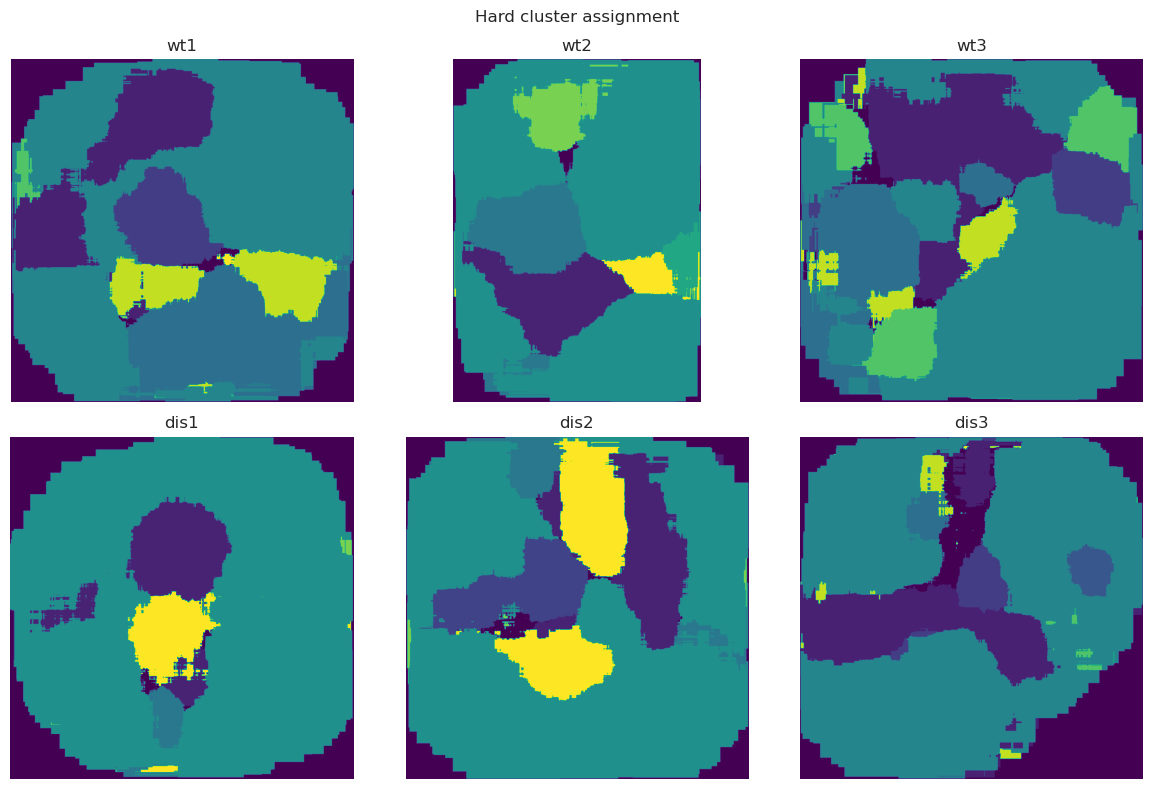

In [36]:
show_raw_one_channel([sp_img.image_properties['niche_argmax'].float() for sp_img in sp_images], cmap="viridis", n_col=3, labels=list_f_names, title="Hard cluster assignment")

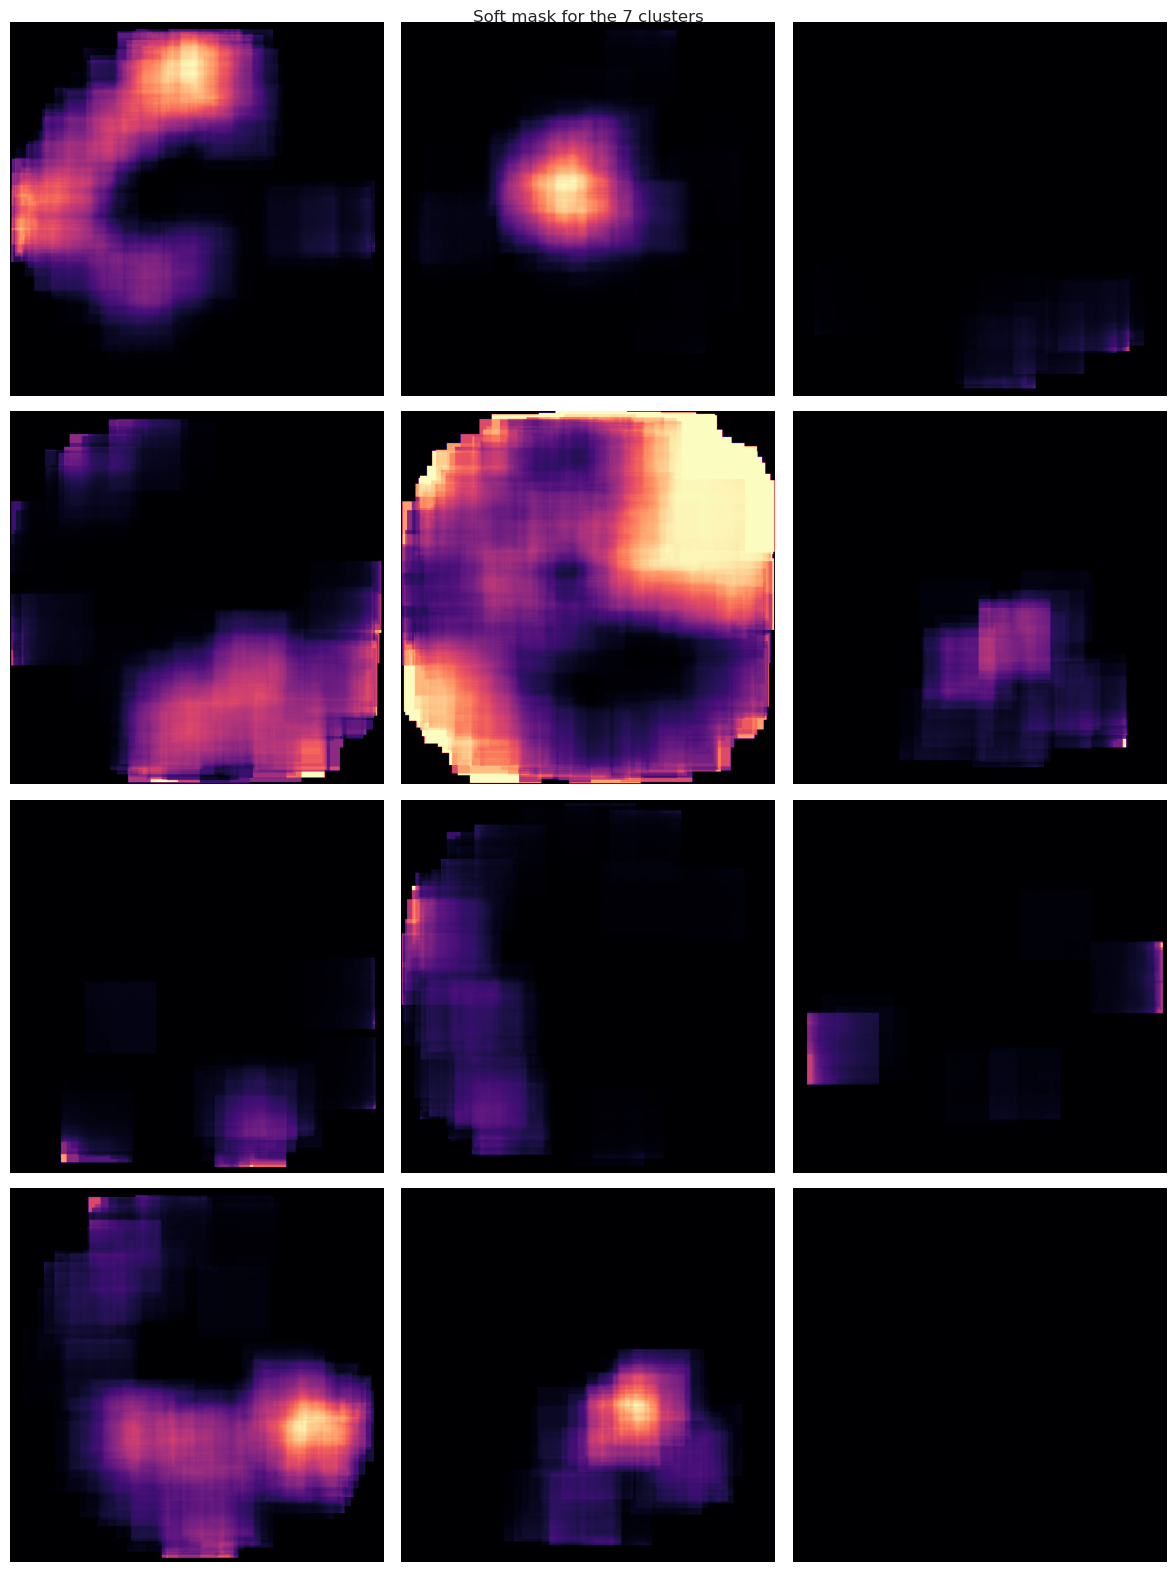

In [37]:
show_raw_one_channel(sp_images[0].image_properties['niche'], cmap="magma", n_col=3, title="Soft mask for the 7 clusters", scale_each=False, in_range=(0.0, 1.0))

### Usage statistics

In [38]:
for sp_img in sp_images:
    soft_usage = sp_img.image_properties['niche'].sum(dim=(-1,-2))
    sp_img.image_properties['soft_usage_fraction'] = soft_usage / soft_usage.sum()
    #print(soft_usage.shape)
    
    
    tmp = sp_img.image_properties['niche_argmax'] 
    hard_usage = torch.bincount(tmp[tmp>=0], minlength=soft_usage.shape[0])
    #print(hard_usage.shape)
    sp_img.image_properties['hard_usage_fraction'] = hard_usage / hard_usage.sum()

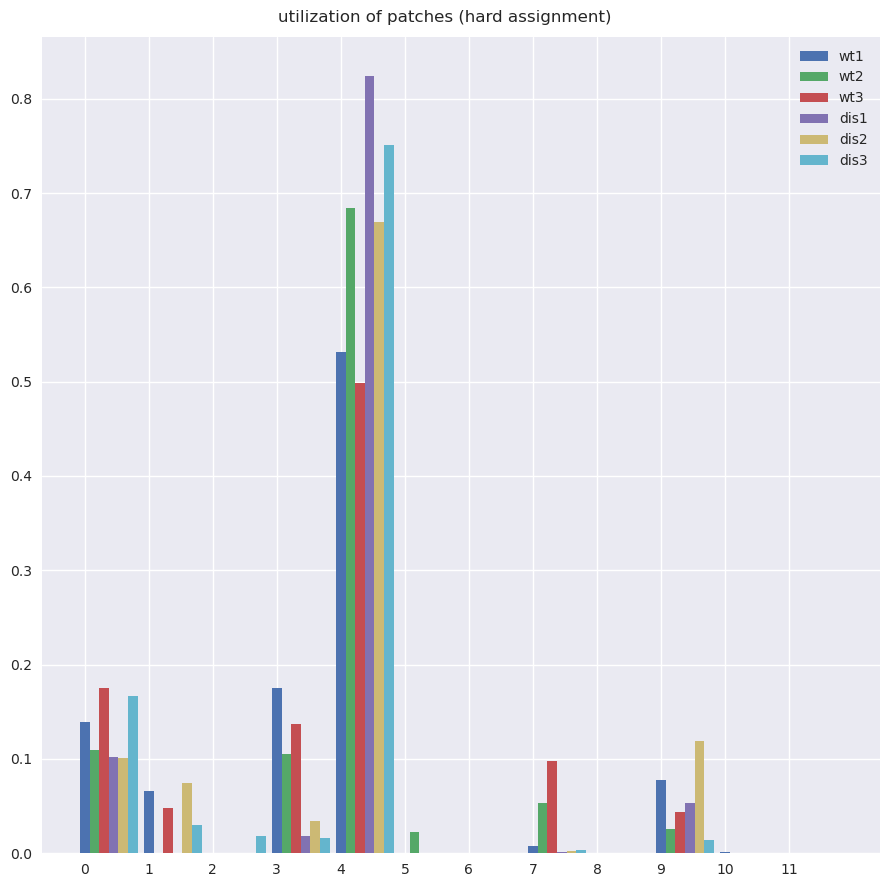

In [39]:
plot_counters([sp_img.image_properties['hard_usage_fraction'] for sp_img in sp_images], dataset_labels=list_f_names, title="utilization of patches (hard assignment)")

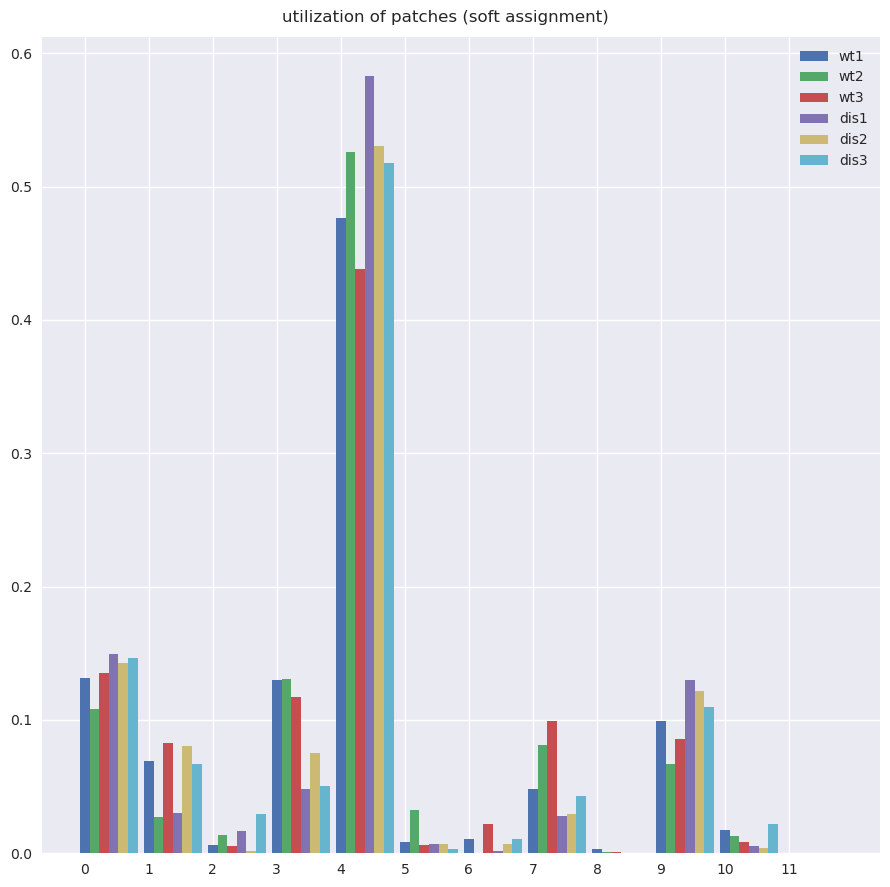

In [40]:
plot_counters([sp_img.image_properties['soft_usage_fraction'] for sp_img in sp_images], dataset_labels=list_f_names, title="utilization of patches (soft assignment)")

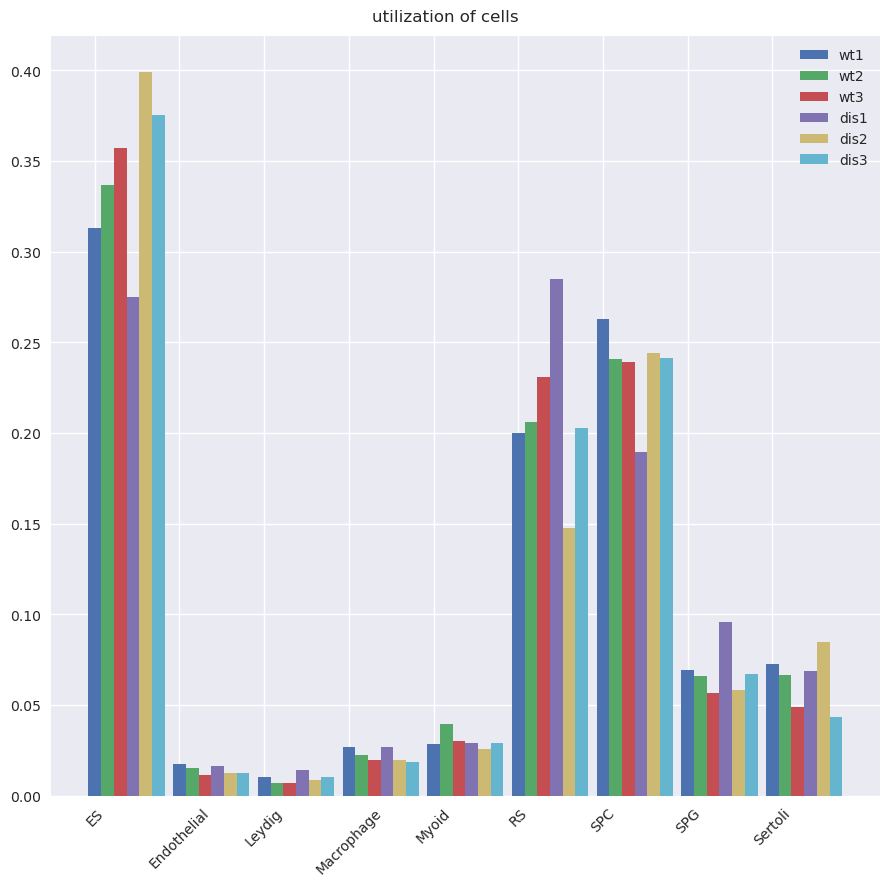

In [41]:
for sp_img in sp_images:
    cell_usage = channel_counter_in_window(sp_img)
    cell_usage_fraction = cell_usage / cell_usage.sum()
    sp_img.image_properties['cell_usage_fraction'] = cell_usage_fraction

plot_counters([sp_img.image_properties['cell_usage_fraction'] for sp_img in sp_images], dataset_labels=list_f_names, title="utilization of cells", x_labels=cell_names)   

### UMAP and CLUSTERING

# Logger

In [ ]:
env_vars = !cat ~/.bash_profile | grep NEPTUNE_API_TOKEN 
NEPTUNE_API_TOKEN = str(env_vars[0].split('\"')[1])

In [ ]:
import neptune.new as neptune
NEPTUNE_PROJECT = "cellarium/tissue-purifier"

exp: neptune.run.Run = neptune.init(project=NEPTUNE_PROJECT,
                                    api_token=NEPTUNE_API_TOKEN,
                                    mode="async",
                                    tags=["clustering"])

In [ ]:
partitions = [leidenalg.CPMVertexPartition, leidenalg.RBConfigurationVertexPartition]
normalizations = [True, False]
resolution_parameters = [0.1, 1.0, 10.0]

for p_type in partitions:
    for norm in normalizations:
        for r in resolution_parameters:
            graph = make_graph(umap_graph, normalized=norm)
            clusters = find_partition(graph, partition_type = p_type, resolution_parameter = r)

            clusters_fig = plot_embeddings(
                embeddings_umap,
                x_label="umap1",
                y_label="umap2",
                title=str(p_type)+"_"+str(norm)+"_"+str(r),
                labels=clusters,
                size=10,
                figsize=(10,10),
                cmap=plt.cm.tab10,
                legend=False,
            )
            exp["clusters"].log(neptune.types.File.as_image(clusters_fig))
        

In [ ]:
exp.stop()

### Can I predict moran?

In [ ]:
x_all = bbone_embeddings
y_all = morans_all
stratify_by = fnames_all

x_train, x_test, y_train, y_test = train_test_split(
    x_all,
    y_all,
    stratify=stratify_by,
    test_size=0.2,
    random_state=1)

mlp_regression = MLPRegressor(
    hidden_layer_sizes=[],
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=100000,
    shuffle=True,
    random_state=1,
    tol=1E-6,
    verbose=False,
    n_iter_no_change=100,
    early_stopping=False)
mlp_regression.fit(x_train, y_train)

r2_test = mlp_regression.score(x_test, y_test)
r2_train = mlp_regression.score(x_train, y_train)

y_test_predicted = mlp_regression.predict(x_test)
y_train_predicted = mlp_regression.predict(x_train)


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(24,8))

axs[0].set_title("train dataset")
axs[0].scatter(y_train, y_train_predicted)
axs[0].set_ylabel("predicted")
axs[0].set_xlabel("actual")

axs[1].set_title("test dataset")
axs[1].scatter(y_test, y_test_predicted)
axs[1].set_ylabel("predicted")
axs[1].set_xlabel("actual")

axs[2].set_title("mlp loss")
axs[2].plot(mlp.loss_curve_)
axs[2].set_ylabel("regressor loss")
axs[2].set_xlabel("iteration")
axs[2].set_yscale("log")
print("We can predict moran with good_accuracy", r2_train, r2_test)

### Can I predict the tissue labels?

In [ ]:


x_all = bbone_embeddings
y_all = fnames_all
stratify_by = fnames_all

x_train, x_test, y_train, y_test = train_test_split(
    x_all,
    y_all,
    stratify=fnames_all,
    test_size=0.2,
    random_state=1)

mlp_classification = MLPClassifier(
    hidden_layer_sizes=[],
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=100000,
    shuffle=True,
    random_state=1,
    tol=1E-6,
    verbose=False,
    n_iter_no_change=100,
    early_stopping=False)

mlp_classification.fit(x_train, y_train)

mean_accuracy_test = mlp_classification.score(x_test, y_test)
mean_accuracy_train = mlp_classification.score(x_train, y_train)

y_test_predicted = mlp_classification.predict(x_test)
y_train_predicted = mlp_classification.predict(x_train)

cm_train = confusion_matrix(y_train, y_train_predicted, labels=mlp_classification.classes_)
cm_test = confusion_matrix(y_test, y_test_predicted, labels=mlp_classification.classes_)

cm_train_disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                       display_labels=mlp_classification.classes_)
cm_test_disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                      display_labels=mlp_classification.classes_)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(24,8))

axs[0].set_title("train dataset")
cm_train_disp.plot(ax=axs[0])

axs[1].set_title("test dataset")
cm_test_disp.plot(ax=axs[1])

axs[2].set_title("mlp loss")
axs[2].plot(mlp_classification.loss_curve_)
axs[2].set_ylabel("regressor loss")
axs[2].set_xlabel("iteration")
axs[2].set_yscale("log")
print("We can predict tissue with excellent accuracy", mean_accuracy_train, mean_accuracy_test)

## Plot

In [ ]:
file_embeddings = "./output_prediction_random-413.pt"

output_prediction_tiling = torch.load(file_embeddings, map_location=torch.device('cpu'))
print("output_prediction_tiling.keys() -->", output_prediction_random.keys())

bbone_embeddings = output_prediction_tiling["features_bbone_ref_trsfm"]
head_embeddings = output_prediction_tiling["features_head_ref_trsfm"]

metadatas = output_prediction_tiling["metadata"]

morans_all = numpy.array([metadata.moran for metadata in metadatas])
fnames_all = numpy.array([metadata.f_name for metadata in metadatas])

## Plot BackBone embeddings

In [ ]:
bbone_embeddings_pca = get_pca(bbone_embeddings)

bbone_embeddings_umap, distances_bbone_nn = get_umap(
    bbone_embeddings, 
    n_neighbors=15, 
    metric='contrastive')

bbone_umap_fig1 = plot_embeddings(
    embeddings=bbone_embeddings_umap,
    size=20,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="Backbone UMAP by tissue",
    colors=None,
    labels=fnames_all,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

bbone_umap_fig2 = plot_embeddings(
    embeddings=bbone_embeddings_umap,
    size=20,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="Backbone UMAP by Moran score",
    colors=morans_all,
    labels=None,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

bbone_pca_fig1 = plot_embeddings(
    embeddings=bbone_embeddings_pca,
    x_label='PCA 1',
    y_label='PCA 2',
    title="Backbone PCA by tissue",
    colors=None,
    labels=fnames_all,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

bbone_pca_fig2 = plot_embeddings(
    embeddings=bbone_embeddings_pca,
    x_label='PCA 1',
    y_label='PCA 2',
    title="Backbone PCA by Moran score",
    colors=morans_all,
    labels=None,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

In [ ]:
bbone_umap_fig1.savefig("./random_umap_tissue.png")
bbone_umap_fig2.savefig("./random_umap_moran.png")

In [ ]:
paths = save_to_local_path([bbone_umap_fig1, bbone_umap_fig2, bbone_pca_fig1, bbone_pca_fig2])
ipyplot.plot_images(paths, max_images=5, img_width=400)

## Plot Head embeddings

In [ ]:
head_embeddings = output_prediction_random["features_head_ref_trsfm"]

head_embeddings_pca = get_pca(head_embeddings)

head_embeddings_umap, distances_head_nn = get_umap(
    bbone_embeddings, 
    n_neighbors=50, 
    metric='contrastive')

head_umap_fig1 = plot_embeddings(
    embeddings=head_embeddings_umap,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="Head UMAP by tissue",
    colors=None,
    labels=f_names,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

head_umap_fig2 = plot_embeddings(
    embeddings=head_embeddings_umap,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="Head UMAP by Moran score",
    colors=moran,
    labels=None,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

head_pca_fig1 = plot_embeddings(
    embeddings=head_embeddings_pca,
    x_label='PCA 1',
    y_label='PCA 2',
    title="Head PCA by tissue",
    colors=None,
    labels=f_names,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

head_pca_fig2 = plot_embeddings(
    embeddings=head_embeddings_pca,
    x_label='PCA 1',
    y_label='PCA 2',
    title="Head PCA by Moran score",
    colors=moran,
    labels=None,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

In [ ]:
paths = save_to_local_path([head_umap_fig1, head_umap_fig2, head_pca_fig1, head_pca_fig2])
ipyplot.plot_images(paths, max_images=5, img_width=400)

# Unsupervised clustering of the Head embeddings

In [ ]:
distances_nn = distances_head_nn
embeddings_umap = head_embeddings_umap

graph_umap = make_graph(distances_nn=distances_head_nn,
                        n_neighbors=50,
                        metric='contrastive'
                       )

partition_umap = compute_partition(graph_umap, resolution_parameter=0.2)
 
cluster_plot = plot_embeddings(
    embeddings=embeddings_umap,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="UMAP",
    colors=None,
    labels=partition_umap.membership,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

display(cluster_plot)

# FROM HERE. MAKE A CLASSIFIER WHICH PREDICTS THE CLUSTERS AND THEN WORK ON TILING. SWITCH IN NEW EMBEDDINGS

### Common import and set random seed

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import torch
import pytorch_lightning as pl
import tissue_purifier as tp

matplotlib.rcParams["figure.dpi"] = 200
torch.manual_seed(config['simulation']['RANDOM_SEED'])
np.random.seed(config['simulation']['RANDOM_SEED'])

### Read in all the csv file

In [ ]:
#data_folder = "/home/jupyter/data/slide-seq/original_data/"
data_folder = "../slide-seq-data"


df_wt1 = pd.read_csv(os.path.join(data_folder, "wt_1.csv"))
df_wt2 = pd.read_csv(os.path.join(data_folder, "wt_2.csv"))
df_wt3 = pd.read_csv(os.path.join(data_folder, "wt_3.csv"))
df_dis1 = pd.read_csv(os.path.join(data_folder, "sick_1.csv"))
df_dis2 = pd.read_csv(os.path.join(data_folder, "sick_2.csv"))
df_dis3 = pd.read_csv(os.path.join(data_folder, "sick_3.csv"))

## Cluster Embeddings

In [ ]:
from tissue_purifier.model_utils import TrainedEmbedding

model_folder = "../trained_model"
model = tp.model_utils.helpers.define_model(
    backbone_type=config["model_settings"]["BACKBONE_TYPE"],
    number_of_channels=config["model_settings"]["INPUT_CHANNELS"],
    num_of_filters=config["model_settings"]["BACKBONE_NUM_FTRS"],
    projection_out_dim=config["model_settings"]["PROJECTION_OUT_DIM"],
)
model.backbone.load_state_dict(torch.load(f"./model.pth")["resnet18_parameters"])
# model.load_state_dict(torch.load(f"{model_folder}/simclr_model_11.pt"))
model = model.cuda()
encoder = TrainedEmbedding(model)

In [ ]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca_aglomerative = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=15)), 
        ("cluster", AgglomerativeClustering(n_clusters=2))
    ]
)


In [ ]:
%%capture
mask_dis2 = tp.evaluation_utils.create_mask_for_sample(
    df_dis2, encoder, pca_aglomerative, config, proba=True, n_crops=1000
)

In [ ]:
df_dis2["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_dis2, mask_dis2, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_dis2["condition"] = df_dis2["nn_probas"].map(lambda x: 0 if x < 0.5 else 1)

In [ ]:
tp.plot_utils.disease_mask(df_dis2, "condition", figsize=(8, 4), title="DIS 2 Clustered Mask")

In [ ]:
%%capture
mask_wt2 = tp.evaluation_utils.create_mask_for_sample(df_wt2, encoder, pca_aglomerative, config, proba=True, n_crops=1000)

In [ ]:
df_wt2["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_wt2, mask_wt2, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_wt2["condition"] = df_wt2["nn_probas"].map(lambda x: 0 if x < 0.5 else 1)
tp.plot_utils.disease_mask(df_wt2, "condition", figsize=(8, 3), title="WT 2 Clustered Mask")

In [ ]:
%%capture
mask_dis1 = tp.evaluation_utils.create_mask_for_sample(df_dis1, encoder, pca_aglomerative, config, proba=True, n_crops=1000)

In [ ]:
df_dis1["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_dis1, mask_dis1, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_dis1["condition"] = df_dis1["nn_probas"].map(lambda x: 0 if x < 0.4 else 1)
tp.plot_utils.disease_mask(df_dis1, "condition", figsize=(8, 4), title="DIS 1 Clustered Mask")

In [ ]:
%%capture
mask_wt1 = tp.evaluation_utils.create_mask_for_sample(df_wt1, encoder, pca_aglomerative, config, proba=True, n_crops=1000)

In [ ]:
df_wt1["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_wt1, mask_wt1, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_wt1["condition"] = df_wt1["nn_probas"].map(lambda x: 0 if x < 0.4 else 1)
tp.plot_utils.disease_mask(df_wt1, "condition", figsize=(8, 4), title="WT 1 Clustered Mask")

## Moran's I Score Evaluation

In [ ]:
%%capture
moran_averaged = tp.evaluation_utils.moran_score_averaged(
    [df_wt1, df_wt2, df_dis1, df_dis2],
    ["WT1", "WT2", "DIS1", "DIS2"]
)

In [ ]:
moran_averaged.columns = ["total", "COND1", "COND2"]
moran_averaged